#Anomaly detection using DS methods and RNN
In this notebook we will analyze anomalies in people behevior by anlayzing their filmed interview.

##Import and preprocesing
We will use google's holistic net that captures face and body keypoints.

In [1]:
!gdown 18zrd1g-2_SWBDfDvoSiJ4y7NEiviezci
!unzip holistic_interface.zip
!rm -rf __MACOSX
!rm holistic_interface.zip
!pip install mediapipe
import holistic_interface

Downloading...
From: https://drive.google.com/uc?id=18zrd1g-2_SWBDfDvoSiJ4y7NEiviezci
To: /content/holistic_interface.zip
100% 3.65k/3.65k [00:00<00:00, 6.60MB/s]
Archive:  holistic_interface.zip
  inflating: help_functions.py       
  inflating: __MACOSX/._help_functions.py  
  inflating: holistic_interface.py   
  inflating: __MACOSX/._holistic_interface.py  
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 19.3 MB/s eta 0:00:00


Upload in here your video (only in mp4 format).

In [2]:
!mkdir output_csv_directory
!mkdir videos
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  file = fn
path = './' + file

import os
if os.path.splitext(path)[1] != ".mp4":
  print("please upload mp4 file")
os.rename(path, "./videos/video.mp4")

Saving video2.mp4 to video2.mp4


Proccesing the input

In [3]:
holistic_interface.process_video_to_coordinates_csv(output_file='video.csv',
                                                    input_file='video.mp4')

##Anomaly detection

###Data-specific preprocessing
We will shape the data in a way that is specific to the data we got. (Meaning we will not save any parameters from this preprocessing for other datasets).

In [54]:
import pandas as pd

In [55]:
df = pd.read_csv("./output_csv_directory/video.csv")

This is a debugging column so we will get rid of it.

In [56]:
df_noTimestamp = df.drop(["timestamp"], axis=1)

In [57]:
(df_noTimestamp.mean() == 0).sum()

468

A lot of columns are without any output (usually because the body parts that those columns represent weren't shown during the video).

In [58]:
df_noZero = df_noTimestamp[df_noTimestamp.columns[~(df_noTimestamp.sum() == 0)]]

In [59]:
df_noZero.mean().describe()

count    1536.000000
mean        0.352752
std         0.352723
min        -0.801253
25%         0.006039
50%         0.461841
75%         0.523827
max         3.214567
dtype: float64

The input data isn't scaled so we will scale it.

In [60]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_scaled = sc.fit_transform(df_noZero)

In [61]:
timestamps = df_scaled.shape[0]

In [62]:
num_of_cols = df_scaled.shape[1]

In [63]:
import numpy as np

In [64]:
import itertools
  
def intervals_extract(iterable):
      
    iterable = sorted(set(iterable))
    for key, group in itertools.groupby(enumerate(iterable),
    lambda t: t[1] - t[0]):
        group = list(group)
        yield [group[0][1], group[-1][1]]

We have a lot of sparse data so we will reduce the dimensionality of the information.

In [65]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.999)
pca.fit(df_scaled)

print(pca.explained_variance_ratio_)

[3.68462964e-01 2.53231911e-01 1.40642819e-01 7.21357567e-02
 4.42508425e-02 4.37923026e-02 1.78599044e-02 1.28121979e-02
 1.08753952e-02 6.38691912e-03 5.31757461e-03 4.16470829e-03
 2.66225195e-03 1.92771646e-03 1.73783678e-03 1.41602084e-03
 1.32801284e-03 1.26126197e-03 1.15536686e-03 1.01903110e-03
 8.04594665e-04 7.19859986e-04 6.58603263e-04 5.49328962e-04
 5.39061377e-04 4.36214665e-04 4.32379853e-04 3.95857971e-04
 2.74661294e-04 2.55751149e-04 2.19231235e-04 2.01358814e-04
 1.82850906e-04 1.63791142e-04 1.43066192e-04 1.40772416e-04
 1.12191721e-04 1.01999870e-04 9.52798999e-05 8.86837079e-05
 7.61058923e-05]


In [66]:
X = pca.transform(df_scaled)

###Robust Z-score


We will see how far the data is from the median by using the method of robust Z-score. It is similar to Z-score method, but since mean and standard deviations are heavily influenced by outliers, we will use median and absolute deviation from median instead.
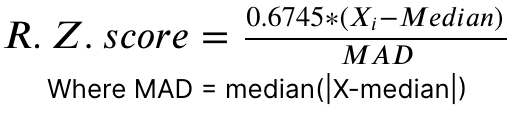

In [17]:
import scipy.stats as stats

If any of the parameters is an outlier we will consider the timestamp outlier.

In [18]:
def ZRscore_outlier(df):
  out = []
  df = df.T
  for col in df:
    med = np.median(col)
    ma = stats.median_abs_deviation(col)
    for index, i in enumerate(col): 
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            out.append(index)
  return sorted(list(set(out)))

In [19]:
ZRScoreOutliers = ZRscore_outlier(X)
isZRScoreOutliers = []
for i in range(timestamps):
  if i in ZRScoreOutliers:
    isZRScoreOutliers.append(1)
  else:
    isZRScoreOutliers.append(0)
isZRScoreOutliers = np.array(isZRScoreOutliers, dtype=np.bool8)

###Anomaly detection algorithms
We will use an ensemble of anomaly detection algorithms and will use a major vote classifier to decide if a timestamp is an outlier or not.

In [67]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest

We assume that there is only 1% of anomalies in the data. All of the algorithms have some kind of threshold so they tune it so it will be only 1% of anomalies on the train set.

In [68]:
outliers_fraction = 0.01

We are using five different algorithms:
 - Robust covariance: we will calculate the covariance matrix (in fact the robust covariance matrix which is more resilient to outliers) and then we will see which timestamps are moving away from the covariance of the dataset.
 - One-Class SVM: the algorithm tries to fit a hyperplane in high dimensional space between the points in the dataset (which are only of one class and therefore the name) while keeping the margin between the points as high as possible.
 - One-Class SVM (SGD): The same but using stochastic gradient descent instead of the dual solution.
 - Isolation Forest: We will train a forest in which each tree inside will decide on a random feature to select and try and split the feature randomly when each leaf is a timestamp. We will expect that anomalies will be easier to split so they will be much higher up the tree when normal samples will be at the bottom as they are harder to split from other normal samples.
 - Local Outlier Factor: a density-based model, which looks around and seeks the number of close samples. If it can't find the required any in a specific radius then it's considered outlier.

In [69]:
anomaly_algorithms = [
    (
        "Robust covariance",
        EllipticEnvelope(contamination=outliers_fraction, random_state=42),
    ),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "One-Class SVM (SGD)",
        make_pipeline(
            Nystroem(gamma=0.1, random_state=42, n_components=150),
            SGDOneClassSVM(
                nu=outliers_fraction,
                shuffle=True,
                fit_intercept=True,
                random_state=42,
                tol=1e-6,
            ),
        ),
    ),
    (
        "Isolation Forest",
        IsolationForest(contamination=outliers_fraction, random_state=42),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=outliers_fraction),
    ),
]


In [70]:
y_preds = []

In [71]:
for name, algorithm in anomaly_algorithms:
    # algorithm.fit(X)

    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(X)
    else:
        y_pred = algorithm.fit(X).predict(X)
    y_preds.append(y_pred)
    print(name)

Robust covariance
One-Class SVM
One-Class SVM (SGD)
Isolation Forest
Local Outlier Factor


###RNN

We will train an RNN that will try to predict the next body and face gestures based on the last few frames. If the RNN will fail to predict that with a large error, we will consider the predicted frame an anomaly.

In [25]:
import torch
import torch.nn as nn
import numpy as np

Simple LSTM network, with two layers. We don't want the network to be too complicated so it will also fit the anomalies.

In [26]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

In [27]:
input_size = num_of_cols
hidden_size = 64
output_size = num_of_cols
sequence_length = 60
learning_rate = 0.001
num_epochs = 10

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Mean squared errors for a regression problem, and Adam optimizer because its good.

In [29]:
model = RNN(input_size, hidden_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Preprocessing

In [30]:
X = []
Y = []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled[i:i+sequence_length])
    Y.append(df_scaled[i+sequence_length])
X = np.array(X)
Y = np.array(Y)
X = torch.from_numpy(X).float()
Y = torch.from_numpy(Y).float()

In [31]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

dataset = TimeSeriesDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

We will train the model for 10 epochs and print the loss after each epoch.

In [32]:
running_loss = 0.0
for epoch in range(num_epochs):
  for i in dataloader:
    inputs, outputs = i
    inputs = inputs.to(device)
    outputs = outputs.to(device)
    
    predictions = model(inputs)

    loss = criterion(predictions, outputs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, running_loss))
  running_loss = 0.0

Epoch [1/10], Loss: 83.0866
Epoch [2/10], Loss: 53.7731
Epoch [3/10], Loss: 46.2829
Epoch [4/10], Loss: 42.6377
Epoch [5/10], Loss: 39.7703
Epoch [6/10], Loss: 37.6383
Epoch [7/10], Loss: 34.9685
Epoch [8/10], Loss: 31.2975
Epoch [9/10], Loss: 27.7798
Epoch [10/10], Loss: 26.1572


We will find the top 1% errors on the dataset.

In [34]:
with torch.no_grad():
    predictions = model(X.to(device))

In [36]:
meanErrors = np.mean(np.abs(predictions.cpu().numpy() - Y.numpy()), axis=1).argsort()
topOnePrecent = int((timestamps-sequence_length)*(1-outliers_fraction)) 
rnnAnomalies = meanErrors[topOnePrecent:]

In [48]:
isRNNOutliers = []
for i in range(timestamps):
  if i in rnnAnomalies:
    isRNNOutliers.append(0)
  else:
    isRNNOutliers.append(1)
isRNNOutliers = np.array(isRNNOutliers, dtype=np.bool8)

##Ensemble model
We will reduce the outputs of the models' predictions to a prediction array by major voting. We want the RNN to have three votes in the voting because it is the strongest model.

In [73]:
y_preds.append(isZRScoreOutliers*2-1)
y_preds.append(isRNNOutliers*2-1)
y_preds.append(isRNNOutliers*2-1)
y_preds.append(isRNNOutliers*2-1)

We will sum all the timestamps and see which are negetive (since the models output is -1 for anomaly and 1 for regular sample).

In [75]:
from functools import reduce
outliers = reduce(lambda num1, num2: num1 + num2, y_preds)

In [76]:
y_predictions = outliers < 0

In [77]:
print("There are", (outliers < 0).sum(), "outliers, in those intervals:\n",  list(intervals_extract(list(np.where(y_predictions)[0]))))

There are 34 outliers, in those intervals:
 [[116, 117], [150, 150], [503, 504], [591, 591], [881, 881], [1104, 1104], [1155, 1156], [1172, 1172], [1472, 1479], [1639, 1639], [1847, 1847], [2599, 2600], [3447, 3454], [3529, 3529], [3531, 3531], [3543, 3543]]


##Outputing the video
We will create a video in which each frame is painted with a red border and slowed down if it is an outlier.
If you want to see the video, download the file `output_video.mp4` from the local runtime.

In [78]:
import cv2

cap = cv2.VideoCapture('./videos/video.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
border_size = 10
out = cv2.VideoWriter('./output_video.mp4', fourcc, 30.0,
                      (int(cap.get(3))+border_size*2, int(cap.get(4))+border_size*2))

index = 0

while cap.isOpened():
  ret, frame = cap.read()
  if not ret:
      break
  
  if y_predictions[index]:
    frame = cv2.copyMakeBorder(
        frame,
        top=border_size,
        bottom=border_size,
        left=border_size,
        right=border_size,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 255]
    )
    for i in range(30):
      out.write(frame)
  else:
    frame = cv2.copyMakeBorder(
        frame,
        top=border_size,
        bottom=border_size,
        left=border_size,
        right=border_size,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]
    )
    out.write(frame)

  index += 1

cap.release()
out.release()
